In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import zipfile

zip_file_path = "dataset/playground-series-s3e3.zip"
extracted_path = "dataset/"

with zipfile.ZipFile(zip_file_path,"r") as zip_ref:
    zip_ref.extractall(extracted_path)
    
print("Zip file Extracted")

Zip file Extracted


In [2]:
df = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")
df.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,...,80,1,10,2,3,10,0,7,8,0
1,1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,...,80,1,4,3,3,4,2,0,3,0
2,2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,...,80,2,4,3,3,3,2,1,2,0
3,3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,...,80,0,15,1,1,6,0,0,2,0
4,4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,...,80,0,31,0,3,31,14,4,10,1


In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == "O":
        le.fit(df[col])
        df[col] = le.transform(df[col])
        test[col] = le.transform(test[col])

In [4]:
x_cols = [col for col in df.columns if col not in ["id","Attrition"]]
y_cols = ["Attrition"]

In [5]:
att = df[df["Attrition"] == 1]
dff = pd.concat([df,att,att,att], axis = 0)

# Shuffle the DataFrame
shuffled_df = dff.sample(frac=1.0, random_state=42)

# Reset the index if needed
shuffled_df.reset_index(drop=True, inplace=True)


In [6]:
X = df[x_cols]
y = df[y_cols]

In [7]:
Xd = shuffled_df[x_cols]
xtest = test[x_cols]
yd = shuffled_df[y_cols]

In [8]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
import xgboost as xgb
import lightgbm as lgbm
from lightgbm import early_stopping, log_evaluation
import optuna

In [11]:
def cross_validation(X,y,estimator,n_splits, xtest=None):

    skf = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)

    acc_scr = []
    f1_scr = []
    auc_scr = []
    
    y_preds_full = np.zeros(len(X))
    
    if xtest is not None:
        preds = np.zeros(len(xtest))
    else:
        preds = None

    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        estimator.fit(X_train, y_train)

        y_preds = estimator.predict(X_test)
        
        y_preds_full += estimator.predict_proba(X)[:,1]/n_splits

        if xtest is not None:
            test_preds = estimator.predict_proba(xtest)[:, 1] / n_splits
            if preds is None:
                preds = test_preds
            else:
                preds += test_preds

        acc_scr.append(accuracy_score(y_test, y_preds))
        f1_scr.append(f1_score(y_test, y_preds))
        auc_scr.append(roc_auc_score(y_test, estimator.predict_proba(X_test)[:, 1]))

    avg_acc = round(np.mean(acc_scr), 4)
    avg_f1 = round(np.mean(f1_scr), 4)
    avg_roc = round(np.mean(auc_scr), 4)

    print(f"Average accuracy score of {n_splits} is : {avg_acc}")
    print(f"Average f1 score of {n_splits} is       : {avg_f1}")
    print(f"Average roc score of {n_splits} is      : {avg_roc}")

    return preds, y_preds_full

        "verbose" :-1,
        "force_col_wise":True,
        "boosting_type": trial.suggest_categorical('boosting_type',['gbdt','dart','goss']),
        'num_iterations' : trial.suggest_int('num_iterations',200,500,step=50),
        "num_leaves": trial.suggest_int("num_leaves", 3, 10),
        "max_depth": trial.suggest_int("max_depth", 3, 5),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5,log=True),
        'scale_pos_weight': trial.suggest_int('scale_pos_weight',2,7),
        'colsample_bytree' :trial.suggest_float('colsample_bytree',0.5,0.8,step=0.1),
        'reg_alpha' : trial.suggest_int('reg_alpha',2,10,step=1),
        'reg_lambda' : trial.suggest_int('reg_lambda',2,10,step=1),
        #"bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        #"bagging_freq": trial.suggest_int("bagging_freq", 1, 8),
        'n_jobs' : -1,
        'metric': 'AUC',
        'verbose': 0  

In [12]:
%%time

base_params = { "objective": ["binary"],
                    "metric": ["auc"],
                    "verbose": [-100],
                    "n_jobs": [-1],
                    "random_state" : [42],
                    "force_col_wise":[True]
                    }



params = {
            "boosting_type": ['gbdt'],
            
            # alias reg_alpha
            "reg_alpha": [0],
            # alias reg_lmabda
            "reg_lambda": [0.001],
            "learning_rate": [0.01],
            
            # Num of boosting rounds
            "n_estimators": [500],
            # maximum number of leaves | increase for better score/will overfit default = 31
            "num_leaves": [15],
            # depth of tree, -1 for full depth
            "max_depth": [5],
            # Min samples in leaf for split
            "min_child_samples": [15],
            'scale_pos_weight': [7],
            
            # alias feature_fraction, basically number of columns
            "colsample_bytree": [0.5],
            # alias bagging_fraction, fraction of sample of whole train data
            "subsample": [0.3],
            # alias bagging_freq after how many iters get smaple again
            "subsample_freq": [3]
}

params.update(base_params)

lgbm_clf = lgbm.LGBMClassifier(random_state=42)
    
grid_lgbm = GridSearchCV(estimator=lgbm_clf,
                            param_grid=params,
                            cv=5,
                            verbose=True,
                            scoring='roc_auc')


CPU times: total: 0 ns
Wall time: 0 ns


In [13]:
grid_lgbm.fit(X,y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42),
             param_grid={'boosting_type': ['gbdt'], 'colsample_bytree': [0.5],
                         'force_col_wise': [True], 'learning_rate': [0.01],
                         'max_depth': [5], 'metric': ['auc'],
                         'min_child_samples': [15], 'n_estimators': [500],
                         'n_jobs': [-1], 'num_leaves': [15],
                         'objective': ['binary'], 'random_state': [42],
                         'reg_alpha': [0], 'reg_lambda': [0.001],
                         'scale_pos_weight': [7], 'subsample': [0.3],
                         'subsample_freq': [3], 'verbose': [-100]},
             scoring='roc_auc', verbose=True)

In [14]:
print(grid_lgbm.best_params_)
print(grid_lgbm.best_score_)

{'boosting_type': 'gbdt', 'colsample_bytree': 0.5, 'force_col_wise': True, 'learning_rate': 0.01, 'max_depth': 5, 'metric': 'auc', 'min_child_samples': 15, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 15, 'objective': 'binary', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0.001, 'scale_pos_weight': 7, 'subsample': 0.3, 'subsample_freq': 3, 'verbose': -100}
0.836610112230875


In [15]:
best_lgbm = grid_lgbm.best_estimator_

In [16]:
cross_validation(X,y,best_lgbm,5, None)
print("-"*80)
cross_validation(Xd,yd,best_lgbm,5, None)

Average accuracy score of 5 is : 0.8712
Average f1 score of 5 is       : 0.4644
Average roc score of 5 is      : 0.8266
--------------------------------------------------------------------------------
Average accuracy score of 5 is : 0.7953
Average f1 score of 5 is       : 0.7719
Average roc score of 5 is      : 0.9535


(None,
 array([0.09041199, 0.25038742, 0.48504896, ..., 0.13641922, 0.20802493,
        0.11546317]))

In [17]:
val = cross_validation(X,y,best_lgbm,5, xtest=xtest)[0]
preds_full = cross_validation(X,y,best_lgbm,5, xtest=xtest)[1]

Average accuracy score of 5 is : 0.8712
Average f1 score of 5 is       : 0.4644
Average roc score of 5 is      : 0.8266
Average accuracy score of 5 is : 0.8712
Average f1 score of 5 is       : 0.4644
Average roc score of 5 is      : 0.8266


In [18]:
preds_full

array([0.24914696, 0.16373493, 0.02216226, ..., 0.92648543, 0.03742146,
       0.16565993])

### ROC_AUC Calculation

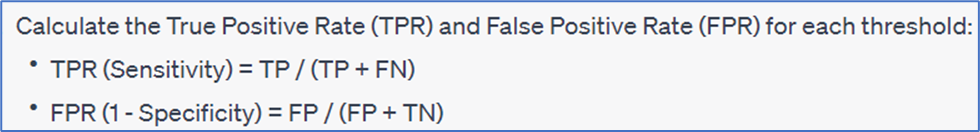

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

rc = {
    "axes.facecolor": "#FFFEF8",
    "figure.facecolor": "#FFFEF8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
grn = Style.BRIGHT + Fore.GREEN
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL


In [20]:
def labels_with_thresh(preds_full,optimal_threshold):
    pred_labels =[]
    for i in preds_full:
        if i > optimal_threshold:
            pred_labels.append(1)
        else:
            pred_labels.append(0)
    return pred_labels

from sklearn.metrics import confusion_matrix

def get_fpr_tpr(preds_full, divs = 500):
    
    arr1 = np.linspace(0,1,divs)
    arr2 = np.array([1.5])
    thresholds = np.concatenate((arr1,arr2), axis=0)
    
    fpr_ = []
    tpr_ = []
    for i in thresholds:
        new_pred_labels = labels_with_thresh(preds_full,i)
        cf_matrix = confusion_matrix(y,new_pred_labels)
        TN, FP = cf_matrix[0][0], cf_matrix[0][1]
        FN, TP = cf_matrix[1][0], cf_matrix[1][1]
        
        ## FPR looks like Recall of 0
        FPR = FP/(FP+TN)
        fpr_.append(FPR)
        
        ## TPR looks like Recall of  1
        TPR = TP/(TP+FN)
        tpr_.append(TPR) 
        
    fpr_ = np.array(fpr_)
    tpr_ = np.array(tpr_)
    thresh_value = thresholds[np.argmax(tpr_ - fpr_)]
    return fpr_,tpr_,thresholds,thresh_value

In [21]:
from sklearn.metrics import roc_curve
# thresholds --> for each thresholds compute fpr and tpr

fpr, tpr, thresholds = roc_curve(y,preds_full) 
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.40370874141251384

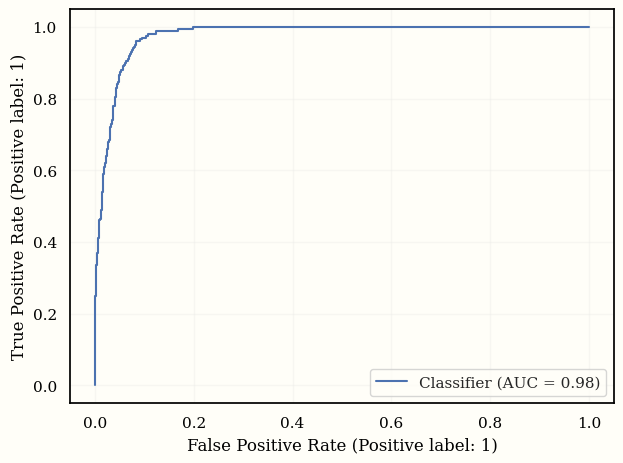

In [59]:
from sklearn import metrics
RocCurveDisplay.from_predictions(df.Attrition, preds_full)
plt.tight_layout()
plt.show()

In [22]:
fpr_1,tpr_1, threshs, thresh_val_1 = get_fpr_tpr(preds_full,divs=200)  

In [23]:

print(threshs[np.argmax(tpr_1-fpr_1)])
print(thresh_val_1)

print(roc_auc_score(y, labels_with_thresh(preds_full,threshs[np.argmax(tpr_1-fpr_1)])))
print(roc_auc_score(y, labels_with_thresh(preds_full,optimal_threshold)))

0.4020100502512563
0.4020100502512563
0.9380230196343942
0.9355230196343941


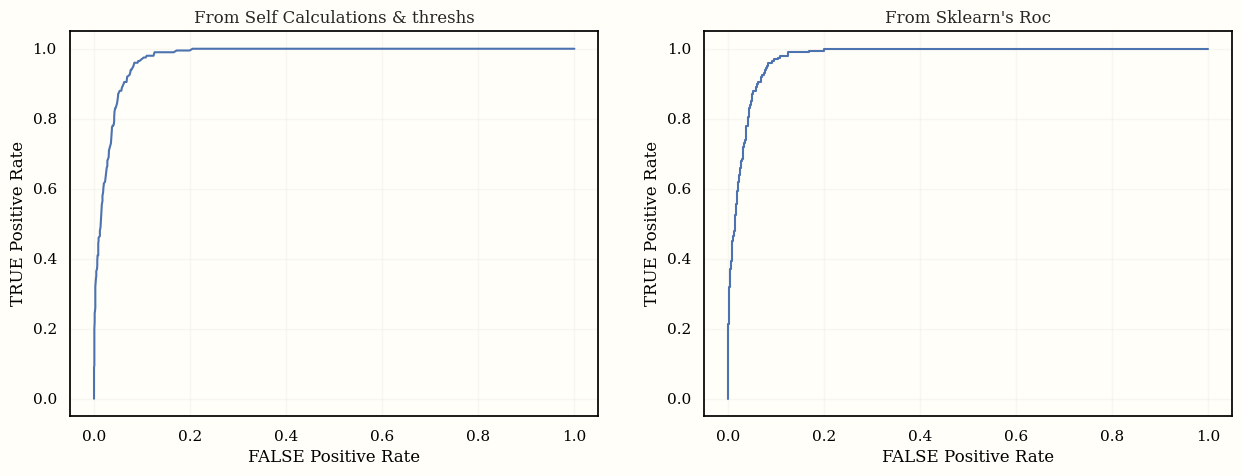

In [24]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(fpr_1,tpr_1)
ax[0].set_title("From Self Calculations & threshs")
ax[1].plot(fpr, tpr)
ax[1].set_title("From Sklearn's Roc")

for ax in ax.flat:
    ax.set_xlabel("FALSE Positive Rate") 
    ax.set_ylabel("TRUE Positive Rate") 
plt.show()

In [25]:
df["pred_labels"] = np.array(labels_with_thresh(preds_full,thresh_val_1))
df["pred_probs"] = np.array(preds_full)
df.head(2)

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,pred_labels,pred_probs
0,0,36,1,599,1,24,3,3,1,4,...,10,2,3,10,0,7,8,0,0,0.249147
1,1,35,2,921,2,8,3,4,1,1,...,4,3,3,4,2,0,3,0,0,0.163735


### Confusion matrix Calculation and MEtrics Calculation

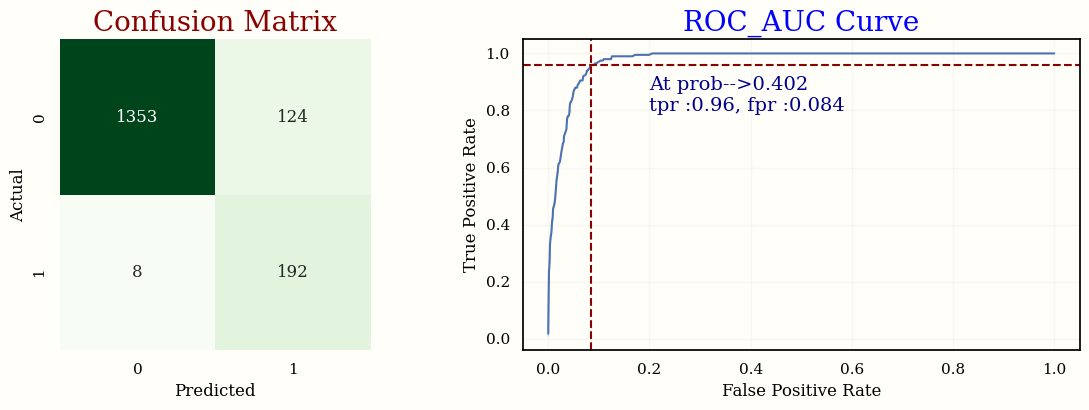

In [26]:
cf_matrix  = confusion_matrix(df.Attrition, df.pred_labels)
tp = round(tpr_1[np.argmax(tpr_1-fpr_1)],4)
fp = round(fpr_1[np.argmax(tpr_1-fpr_1)],4)


fig, ax = plt.subplots(1,2, figsize =(14,5), layout = "constrained")

sns.heatmap(cf_matrix,annot=True, fmt='d',cbar=False, cmap='Greens', ax=ax[0])
ax[0].set_title("Confusion Matrix", size = 20, color="darkred")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("Actual")
ax[0].set_aspect('equal','box')


sns.lineplot(x = fpr_1, y = tpr_1, ax=ax[1])
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].set_title("ROC_AUC Curve", size = 20, color="blue")
ax[1].axhline(y = tpr_1[np.argmax(tpr_1-fpr_1)], linestyle = "--", color = "darkred")
ax[1].axvline(x = fpr_1[np.argmax(tpr_1-fpr_1)], linestyle = "--",  color = "darkred")
ax[1].text(0.2, 0.8,"At prob-->"+str(round(thresh_val_1,3))+"\ntpr :"+str(tp)+", fpr :"+str(fp), fontsize=14,color='darkblue')

plt.tight_layout()
plt.show()



In [27]:
cf_matrix

array([[1353,  124],
       [   8,  192]], dtype=int64)

In [28]:
TN, FP = cf_matrix[0][0], cf_matrix[0][1]
FN, TP = cf_matrix[1][0], cf_matrix[1][1]

In [29]:
prec = TP/(TP+FP)
recal = TP/(TP+FN)
print("Accuracy Score :",round((TP+TN)/(TP+TN+FP+FN),4), round((1353+191)/(1353+124+9+191),4))
print("-"*50)
print("Of all the PREDICTED 1's how many are correct")
print("PRECISION Score : TP/(TP+FP) :",round(TP/(TP+FP),4), round((191)/(191+124),4))
print("-"*50)
print("Of all the ACTUAL 1's how many are correct")
print("RECALL Score : TP/(TP+FN) :",round(TP/(TP+FN),4), round((191)/(191+9),4))
print("-"*50)
print("2* prec*recall/(prec+rec)")
print("RECALL Score : TP/(TP+FN) :",2*prec*recal/(prec+recal))

Accuracy Score : 0.9213 0.9207
--------------------------------------------------
Of all the PREDICTED 1's how many are correct
PRECISION Score : TP/(TP+FP) : 0.6076 0.6063
--------------------------------------------------
Of all the ACTUAL 1's how many are correct
RECALL Score : TP/(TP+FN) : 0.96 0.955
--------------------------------------------------
2* prec*recall/(prec+rec)
RECALL Score : TP/(TP+FN) : 0.7441860465116279


In [30]:
print(accuracy_score(df.Attrition, df.pred_labels))
print("-"*50)
print("The Precision and Recall is calcualted in PYTHON for 1, bcoz 1 is TP")
print("-"*50)
print("PRECISION Score:",precision_score(df.Attrition, df.pred_labels))
print("RECALL Score   :",recall_score(df.Attrition, df.pred_labels))
print("f1 Score       :",f1_score(df.Attrition, df.pred_labels))

0.9212880143112702
--------------------------------------------------
The Precision and Recall is calcualted in PYTHON for 1, bcoz 1 is TP
--------------------------------------------------
PRECISION Score: 0.6075949367088608
RECALL Score   : 0.96
f1 Score       : 0.7441860465116279


In [31]:
from sklearn import metrics

print(metrics.classification_report(df.Attrition, df.pred_labels))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1477
           1       0.61      0.96      0.74       200

    accuracy                           0.92      1677
   macro avg       0.80      0.94      0.85      1677
weighted avg       0.95      0.92      0.93      1677



### Probability Calibration

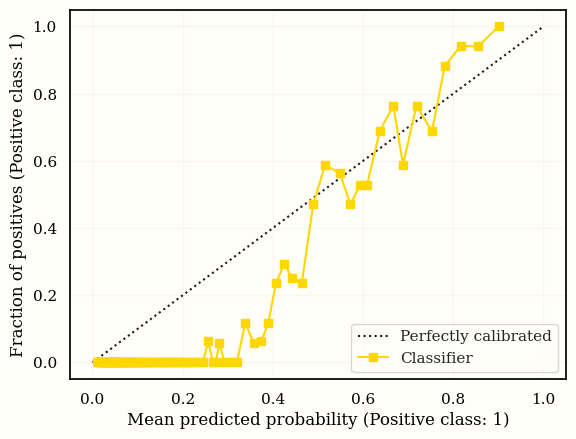

In [44]:
from sklearn.calibration import CalibrationDisplay
CalibrationDisplay.from_predictions(df["Attrition"], df["pred_probs"], n_bins=100,
                                    strategy='quantile',  color='#ffd700')

In [80]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
prob_true, prob_pred = calibration_curve(df.Attrition, df.pred_probs, n_bins=30)
yerr_c= 1
plt.errorbar(x=prob_pred, y=prob_true, yerr=abs(prob_true - prob_pred) * yerr_c, fmt=".k", label='Actual',
                   color=palette[1], capthick=0.5, capsize=3, elinewidth=0.7, ecolor=palette[1])
plt.plot(np.linspace(0, 1, 11),np.linspace(0, 1, 11), linestyle="--", color = 'darkred')
plt.tight_layout()
plt.show()

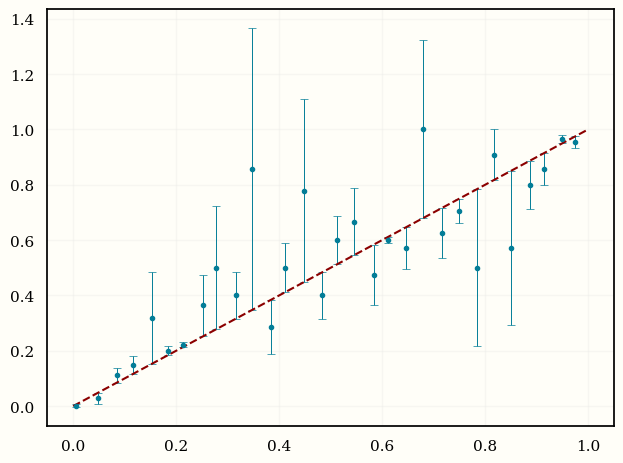

In [99]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(C=99999999999, solver='liblinear', max_iter=1000)
# Convert the Series to a NumPy array and reshape it
X = df.pred_probs.values.reshape(-1, 1)
y = df.Attrition
log_reg.fit(X, y)

log_preds = log_reg.predict_proba(X)[:,1]
log_preds_test = log_reg.predict_proba(val.reshape(-1,1))[:,1]

prob_true, prob_pred = calibration_curve(df.Attrition, log_preds, n_bins=30)
yerr_c= 1
plt.errorbar(x=prob_pred, y=prob_true, yerr=abs(prob_true - prob_pred) * yerr_c, fmt=".k", label='Actual',
                   color=palette[1], capthick=0.5, capsize=3, elinewidth=0.7, ecolor=palette[1])
plt.plot(np.linspace(0, 1, 11),np.linspace(0, 1, 11), linestyle="--", color = 'darkred')
plt.tight_layout()
plt.show()

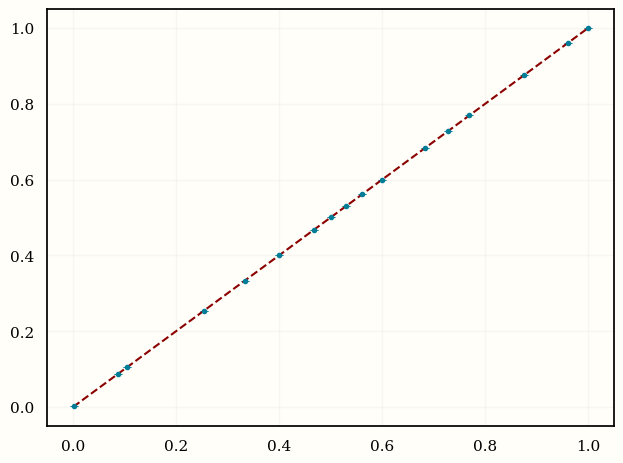

In [106]:
from sklearn.isotonic import IsotonicRegression
iso_reg = IsotonicRegression(out_of_bounds='clip')
# Convert the Series to a NumPy array and reshape it
X = df.pred_probs.values.reshape(-1, 1)
y = df.Attrition
iso_reg.fit(X, y)

iso_preds = iso_reg.predict(X)
iso_preds_test = iso_reg.predict(val.reshape(-1,1))

prob_true, prob_pred = calibration_curve(df.Attrition, iso_preds, n_bins=30)
yerr_c= 1
plt.errorbar(x=prob_pred, y=prob_true, yerr=abs(prob_true - prob_pred) * yerr_c, fmt=".k", label='Actual',
                   color=palette[1], capthick=0.5, capsize=3, elinewidth=0.7, ecolor=palette[1])
plt.plot(np.linspace(0, 1, 11),np.linspace(0, 1, 11), linestyle="--", color = 'darkred')
plt.tight_layout()
plt.show()

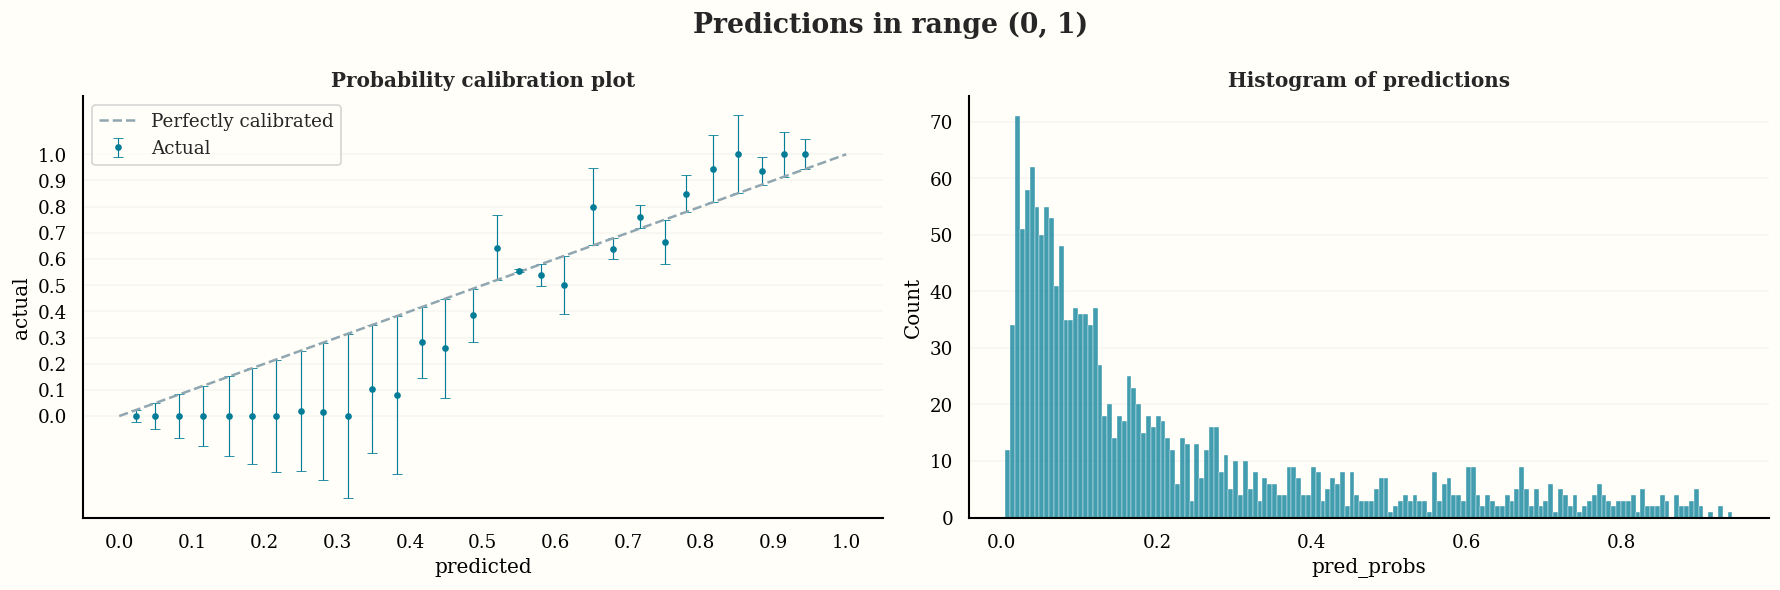

In [36]:
def probability_calibration_plot(y_true=df.Attrition,
                                 y_preds=df.pred_probs,
                                 y_cali=None,
                                 n_bins=30,
                                 yerr_c=1,
                                 xylim=1,
                                 tick=0.1,
                                 calib_method=''):
    
    prob_true, prob_pred = calibration_curve(y_true, y_preds, n_bins=n_bins)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=120)
    ax = ax.flatten()
    ax[0].errorbar(x=prob_pred, y=prob_true, yerr=abs(prob_true - prob_pred) * yerr_c, fmt=".k", label='Actual',
                   color=palette[1], capthick=0.5, capsize=3, elinewidth=0.7, ecolor=palette[1])

    sns.lineplot(x=np.linspace(0, xylim, 11), y=np.linspace(0, xylim, 11), color=palette[-3],
                 label='Perfectly calibrated', ax=ax[0], linestyle='dashed')
    
    if isinstance(y_cali, np.ndarray):
        prob_true_, prob_pred_ = calibration_curve(y_true, y_cali, n_bins=n_bins)
        sns.lineplot(x=prob_pred_, y=prob_true_, color=palette[-5],
                     label=f'{calib_method} Calibration', ax=ax[0], linestyle='solid')
    
    sns.histplot(y_preds, bins=n_bins*5, color=palette[1], ax=ax[1])
    for i, _ in enumerate(ax):
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].xaxis.grid(False)
        ax[i].yaxis.grid(True)

    ax[0].set_title(f'Probability calibration plot', fontdict={'fontweight': 'bold'})
    ax[1].set_title(f'Histogram of predictions', fontdict={'fontweight': 'bold'})

    ax[0].set_xticks(list(np.arange(0, xylim + tick, tick)))
    ax[0].set_yticks(list(np.arange(0, xylim + tick, tick)))
    ax[0].set(xlabel='predicted', ylabel='actual')
    fig.suptitle(f'Predictions in range {(0, xylim)}', ha='center',  fontweight='bold', fontsize=16)
    plt.tight_layout();
    

probability_calibration_plot()

In [107]:
samp_sub = pd.read_csv("dataset/sample_submission.csv")
samp_sub["Attrition"] = iso_preds_test
samp_sub.to_csv("est_sub_lgb_param_cv_iso_preds.csv", index=False)